In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep') 
import matplotlib.style as style
style.use('fivethirtyeight')
import warnings
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from plotnine import *
%matplotlib inline

Load pre-processed Data from previous notebook - Index00

In [3]:
df5 = pd.read_csv('df5.csv')
print(len(df5))
df5.head(10)

30144


,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,RESI,OVER1M
0,222,Manhattan,CHELSEA,07 RENTALS - WALKUP APARTMENTS,2B,765,25,C4,219 WEST 15TH STREET,,...,9,1566.0,6330.0,1901,2,C4,1583840.0,2017-08-31,1,1
1,223,Manhattan,CHELSEA,07 RENTALS - WALKUP APARTMENTS,2B,765,25,C4,219 WEST 15TH STREET,,...,9,1566.0,6330.0,1901,2,C4,416790.0,2017-08-31,1,0
2,224,Manhattan,CHELSEA,07 RENTALS - WALKUP APARTMENTS,2B,765,25,C4,219 WEST 15TH STREET,,...,9,1566.0,6330.0,1901,2,C4,630370.0,2017-08-31,1,0
3,239,Manhattan,CHELSEA,08 RENTALS - ELEVATOR APARTMENTS,2,794,11,D7,155 WEST 18TH,,...,32,10053.0,78882.0,2014,2,D7,2341975.0,2016-10-28,1,1
4,277,Manhattan,CHELSEA,09 COOPS - WALKUP APARTMENTS,2,744,32,C6,309 WEST 20TH STREET,,...,24,4600.0,12200.0,1850,2,C6,282000.0,2016-10-19,1,0
5,2587,Manhattan,FLATIRON,08 RENTALS - ELEVATOR APARTMENTS,2,844,8,D6,9 EAST 16TH STREET,,...,16,4600.0,30680.0,1900,2,D6,489854.0,2017-01-27,1,0
6,2588,Manhattan,FLATIRON,08 RENTALS - ELEVATOR APARTMENTS,2,844,8,D6,9 EAST 16TH STREET,,...,16,4600.0,30680.0,1900,2,D6,576299.0,2017-01-27,1,0
7,4173,Manhattan,GREENWICH VILLAGE-WEST,01 ONE FAMILY DWELLINGS,1,585,69,A5,2 GROVE COURT,,...,1,384.0,1152.0,1901,1,A5,1375000.0,2016-10-07,1,1
8,4199,Manhattan,GREENWICH VILLAGE-WEST,07 RENTALS - WALKUP APARTMENTS,2A,588,32,C2,38 BARROW STREET,,...,5,2171.0,3524.0,1900,2,C2,313000.0,2017-05-23,1,0
9,4800,Manhattan,HARLEM-CENTRAL,01 ONE FAMILY DWELLINGS,1,1942,58,A4,288 W. 137TH STREET,,...,1,1549.0,3036.0,1910,1,A4,2300000.0,2016-11-30,1,1


Would like to count number of data available on every borough to make us aware the data availability. 
Apparently a lot of data from Manhattan has been shaved off due to the criteria we established (price range -- 100k - 4m, squarefootage -- < 20,000, etc)

In [4]:
df5.groupby('BOROUGH').count()

,Unnamed: 0,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,...,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,RESI,OVER1M
BOROUGH,,,,,,,,,,,,,,,,,,,,,
Bronx,3561,3561,3561,3561,3561,3561,3561,3561,3561,3561,...,3561,3561,3561,3561,3561,3561,3561,3561,3561,3561
Brooklyn,11221,11221,11221,11221,11221,11221,11221,11221,11221,11221,...,11221,11221,11221,11221,11221,11221,11221,11221,11221,11221
Manhattan,204,204,204,204,204,204,204,204,204,204,...,204,204,204,204,204,204,204,204,204,204
Queens,10367,10367,10367,10367,10367,10367,10367,10367,10367,10367,...,10367,10367,10367,10367,10367,10367,10367,10367,10367,10367
Staten Island,4791,4791,4791,4791,4791,4791,4791,4791,4791,4791,...,4791,4791,4791,4791,4791,4791,4791,4791,4791,4791


In [6]:
from patsy import dmatrices

In [7]:
def plot_confusion_matrix(cm, normalize=True, digits=4):
    plt_df = (pd.DataFrame(cm)
              .reset_index()
              .melt(id_vars='index')
              .assign(index = lambda d: pd.Categorical(d['index'], d['index'].unique()[::-1], ordered=True),
                      variable = lambda d: pd.Categorical(d['variable'], d['variable'].unique(), ordered=True))
              .rename(columns={'index':'true label', 'variable':'predicted label'})
             )
    
    if normalize:
        plt_df = (plt_df
                  .assign(true_total = lambda d: d.groupby('true label')['value'].transform(lambda x: x.sum()))
                  .assign(value = lambda d: (d['value'] / d['true_total']).round(digits))
                 )
        
    plt = (ggplot(plt_df, aes(x='predicted label', y='true label'))
            + geom_tile(aes(fill='value')) 
            + geom_text(aes(label='value'))
            + theme_minimal()
            + scale_fill_gradient(low = "snow", high = "steelblue")
            + theme(legend_title=element_blank())
           )
    
    return plt

Train Test Split is done without Borough in mind at the moment (without imposing dummy variable to the model)

In [15]:
from sklearn.model_selection import train_test_split
#Define X and y
X = df5[['YEAR BUILT', 'TOTAL UNITS', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS'
           ]] #features we think may help predict y
y = df5['OVER1M'] #what we want to predict

X_tr, X_te, y_tr, y_te = train_test_split(X, y, random_state = 0)
#A brief preview of our train test split
print(len(X_tr), len(X_te), len(y_tr), len(y_te))


22608 7536 22608 7536


In [16]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=0)

# Logistic Regression

In [17]:
%%time
params = {
    'C': np.logspace(-2, 2, num=10)
}

mod = LogisticRegression(multi_class='multinomial', solver='lbfgs')
gscv = GridSearchCV(mod, params, cv=5, refit=True, return_train_score=True)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    gscv.fit(X_tr, y_tr)

CPU times: user 31 s, sys: 912 ms, total: 31.9 s
Wall time: 8.33 s


In [18]:
print(gscv.best_estimator_)
cv_results = pd.DataFrame(gscv.cv_results_)
print('Train score:', cv_results.loc[lambda d: d['rank_test_score'] == 1, 'mean_train_score'].values[0])
print('Test score:', cv_results.loc[lambda d: d['rank_test_score'] == 1, 'mean_test_score'].values[0])

LogisticRegression(C=0.027825594022071243, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)
Train score: 0.8181948802738672
Test score: 0.8182501769285209


Data Input (Train)

/Users/adriansubagyo/anaconda3/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/Users/adriansubagyo/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/adriansubagyo/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


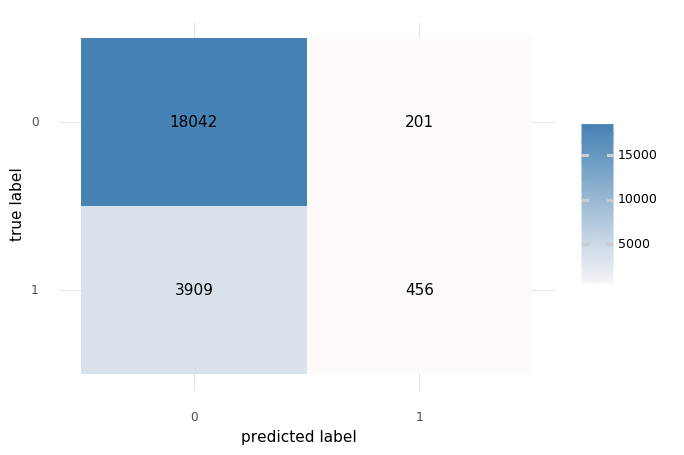

<ggplot: (7529516380)>

In [19]:
pred = gscv.best_estimator_.predict(X_tr)
cm = confusion_matrix(y_tr, pred)
plot_confusion_matrix(cm, normalize=False)

Data Input (Test): to indicate precision of our model predictability. 


"< 1M prediction would get 82% correct" and 68% for" >1M prediction."

/Users/adriansubagyo/anaconda3/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/Users/adriansubagyo/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/adriansubagyo/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


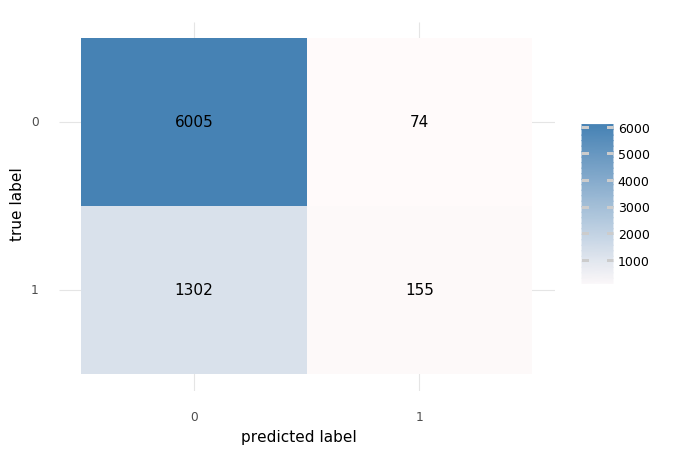

<ggplot: (7530615416)>

In [20]:
pred = gscv.best_estimator_.predict(X_te)
cm = confusion_matrix(y_te, pred)
plot_confusion_matrix(cm, normalize=False)

# Dummy Variables 

In [21]:
# to put Borough into account, we have to use dummy variables

Borough, Land sqft, Gross sqft, total units into account

In [22]:
y, X = dmatrices('OVER1M ~ 0 + BOROUGH + Q("LAND SQUARE FEET") + Q("GROSS SQUARE FEET") + Q("TOTAL UNITS")',
                df5, return_type = "dataframe")

In [23]:
X.columns

Index(['BOROUGH[Bronx]', 'BOROUGH[Brooklyn]', 'BOROUGH[Manhattan]',
       'BOROUGH[Queens]', 'BOROUGH[Staten Island]', 'Q("LAND SQUARE FEET")',
       'Q("GROSS SQUARE FEET")', 'Q("TOTAL UNITS")'],
      dtype='object')

In [24]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, random_state = 0)
#A brief preview of our train test split
print(len(X_tr), len(X_te), len(y_tr), len(y_te))
X_tr.shape

22608 7536 22608 7536


(22608, 8)

In [ ]:
# for boro in ['BOROUGH[T.Brooklyn]', 'BOROUGH[T.Manhattan]',
#        'BOROUGH[T.Queens]', 'BOROUGH[T.Staten Island]']:
#     print(boro, len(X_tr[X_tr[boro] == 1]))
    
# from functools import reduce

# bronx = X_tr[reduce(
#     # Reducer function
#     (lambda x, y: x & y),
#     # Input to reduce
#     [X_tr[boro] == 0 for boro in ['BOROUGH[T.Brooklyn]', 'BOROUGH[T.Manhattan]',
#        'BOROUGH[T.Queens]', 'BOROUGH[T.Staten Island]']])]
# print('Bronx', len(bronx))

In [25]:
%%time
params = {
    'C': np.logspace(-2, 2, num=10)
}

mod = LogisticRegression(multi_class='multinomial', solver='lbfgs')
gscv = GridSearchCV(mod, params, cv=5, refit=True, return_train_score=True)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    gscv.fit(X_tr, y_tr)

CPU times: user 47.8 s, sys: 1.29 s, total: 49.1 s
Wall time: 12.4 s


In [26]:
print(gscv.best_estimator_)
cv_results = pd.DataFrame(gscv.cv_results_)
print('Train score:', cv_results.loc[lambda d: d['rank_test_score'] == 1, 'mean_train_score'].values[0])
print('Test score:', cv_results.loc[lambda d: d['rank_test_score'] == 1, 'mean_test_score'].values[0])

LogisticRegression(C=0.5994842503189409, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)
Train score: 0.8241551919846095
Test score: 0.8243984430290163


Increase in Train and test score, to indicate model is more accurate

/Users/adriansubagyo/anaconda3/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/Users/adriansubagyo/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/adriansubagyo/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


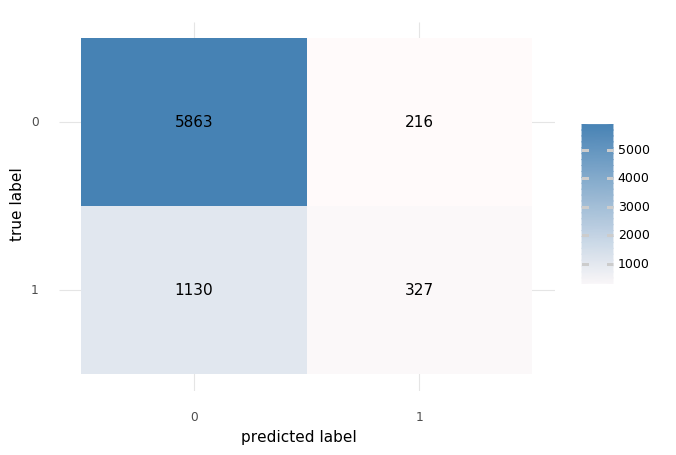

<ggplot: (7530775893)>

In [27]:
pred = gscv.best_estimator_.predict(X_te)
cm = confusion_matrix(y_te, pred)
plot_confusion_matrix(cm, normalize=False)

This model is more accurate as if putting Borough into account.
"< 1M prediction would get 83% correct" and 60% for" >1M prediction." 

# Gradient Boosting

In [28]:
%%time
params = { 
    'n_estimators': [50, 100],
    'subsample': [0.25, 0.50],
    'max_depth' : [2, 4],
    'min_samples_split': [50, 100],
    'min_samples_leaf': [50, 100]
}

mod = GradientBoostingClassifier()
gscv = GridSearchCV(mod, params, cv=5, refit=True, return_train_score=True)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    gscv.fit(X_tr, y_tr)

CPU times: user 1min 35s, sys: 641 ms, total: 1min 36s
Wall time: 1min 36s


In [29]:
print(gscv.best_estimator_)
cv_results = pd.DataFrame(gscv.cv_results_)
print('Train score:', cv_results.loc[lambda d: d['rank_test_score'] == 1, 'mean_train_score'].values[0])
print('Test score:', cv_results.loc[lambda d: d['rank_test_score'] == 1, 'mean_test_score'].values[0])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=100, min_samples_split=100,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)
Train score: 0.845939513076674
Test score: 0.8396142958244869


Increase in Train and test score, to indicate model is more accurate

/Users/adriansubagyo/anaconda3/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/Users/adriansubagyo/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/adriansubagyo/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


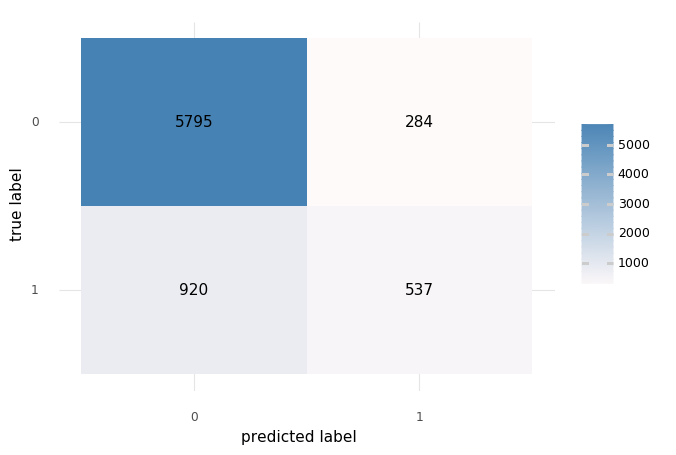

<ggplot: (7529621347)>

In [30]:
pred = gscv.best_estimator_.predict(X_te)
cm = confusion_matrix(y_te, pred)
plot_confusion_matrix(cm, normalize=False)

Borough 

In [43]:
y, X = dmatrices('OVER1M ~ 0 + BOROUGH + Q("LAND SQUARE FEET") + Q("GROSS SQUARE FEET") + RESI',
                df5, return_type = "dataframe")

In [45]:
%%time
params = { 
    'n_estimators': [50, 100],
    'subsample': [0.25, 0.50],
    'max_depth' : [2, 4],
    'min_samples_split': [50, 100],
    'min_samples_leaf': [50, 100]
}

mod = GradientBoostingClassifier()
gscv = GridSearchCV(mod, params, cv=5, refit=True, return_train_score=True)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    gscv.fit(X_tr, y_tr)

CPU times: user 1min 37s, sys: 580 ms, total: 1min 37s
Wall time: 1min 38s


In [33]:
print(gscv.best_estimator_)
cv_results = pd.DataFrame(gscv.cv_results_)
print('Train score:', cv_results.loc[lambda d: d['rank_test_score'] == 1, 'mean_train_score'].values[0])
print('Test score:', cv_results.loc[lambda d: d['rank_test_score'] == 1, 'mean_test_score'].values[0])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=100,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)
Train score: 0.8492016222890554
Test score: 0.8419585987261147


Increase in Train and test score, to indicate model is more accurate

/Users/adriansubagyo/anaconda3/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/Users/adriansubagyo/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/adriansubagyo/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


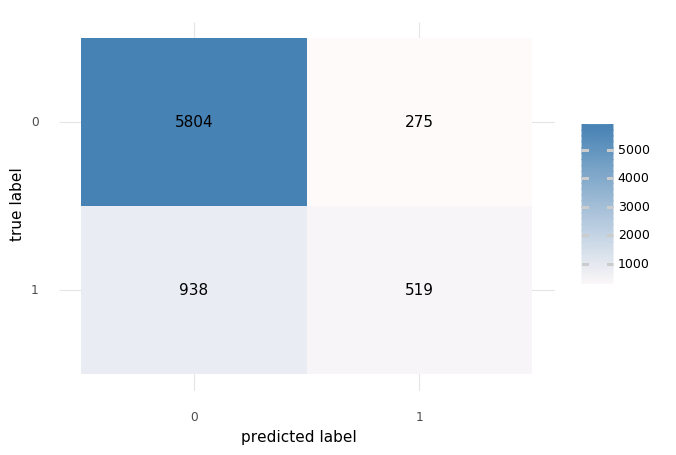

<ggplot: (7530448392)>

In [46]:
pred = gscv.best_estimator_.predict(X_te)
cm = confusion_matrix(y_te, pred)
plot_confusion_matrix(cm, normalize=False)

This model is more accurate as if putting Building Category (Resi / Commercial) as if its  into account.
"< 1M prediction would get 86% correct" and 65% for" >1M prediction." 
To conclude, model is improved. The biggest factor to to determine if a property is valued more or less than 1 Million  is from Borough, Land sqft, and property type (resi / commercial).